[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# Anomaly Detection - Isolation Forest

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 21/04/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0072AnomalyDetectionIsolationForest.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import average_precision_score, auc, confusion_matrix, f1_score, precision_recall_curve, roc_curve

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [2]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())


In [3]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2

DATA_FILE_URL = r'https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv'


In [4]:
# Courses Packages
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotLabelsHistogram, PlotScatterData


In [5]:
# General Auxiliary Functions


## Anomaly Detection by Isolation Forest

In this note book we'll use the [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest) approach for anomaly detection.  
The intuition in _Isolation Forest_ is that the inliers are dense and hence in order to separate a sample from the rest many splits are needed.

This notebook introduces:

1. Working on real world data of credit card fraud.
2. Working with the `IsolationForest` class.
3. Comparing supervised approach to unsupervised approach.

* <font color='brown'>(**#**)</font> Isolation Forest is a tree based model (Ensemble).

* <font color='red'>(**?**)</font> Balance wise, how do you expect the data to look like?

In [6]:
# Parameters

# Data
numSamples = 500
noiseLevel = 0.1

# Model
numEstimators       = 50
contaminationRatio  = 'auto'

# Visualization

numGrdiPts = 201


## Generate / Load Data

In this notebook we'll use the [`creditcard`](https://www.openml.org/search?type=data&id=1597) data set.

The datasets contains transactions made by credit cards in September 2013 by european cardholders.  
This dataset present transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions.  
The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a **PCA transformation** in order to preserve confidentiality.

* <font color='brown'>(**#**)</font> The features: `V1`, `V2`, ..., `V28` the PCA transformed data.
* <font color='brown'>(**#**)</font> The `Class` column is the labeling where `Class = 1` means a fraud transaction.


In [7]:
# Load Data

dfData = pd.read_csv(DATA_FILE_URL)


print(f'The features data shape: {dfData.shape}')


The features data shape: (284807, 31)


### Plot the Data

In [8]:
# Plot the Data

dfData.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


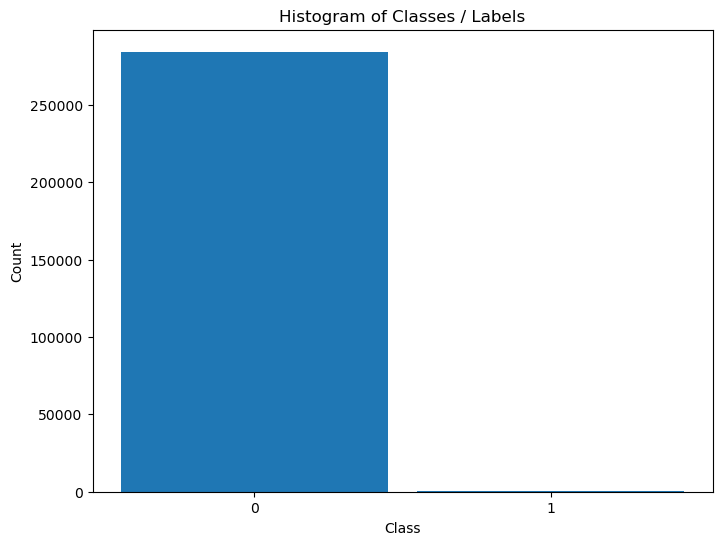

In [9]:
# Histogram of Labels

hA = PlotLabelsHistogram(dfData['Class'])

The data is highly imbalanced. Hence we might treat the fraud cases as outliers.

* <font color='red'>(**?**)</font> Given the data as is, is that a supervised or unsupervised problem?
* <font color='red'>(**?**)</font> Which approach would work better?

## Pre Process Data

We'll remove the time data and separate the class data.  
We'll also convert the data into numeric form (NumPy arrays).

In [10]:
mX = dfData.drop(columns = ['Time', 'Class']).to_numpy()
vY = dfData['Class'].to_numpy()

## Applying Outlier Detection - Isolation Forest

This section applies the [`IsolationForest`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) algorithm.  
The _Unsupervised Model_ is compared to a supervised model.

In [11]:
# Applying the Model
# UnSupervised Model - Isolation Forest

oIsoForestOutDet = IsolationForest(n_estimators = numEstimators, contamination = contaminationRatio)
oIsoForestOutDet = oIsoForestOutDet.fit(mX)

In [12]:
# Applying the Model
# Supervised Model - Random Forest

oRndForestCls = RandomForestClassifier(n_estimators = numEstimators, oob_score = True, n_jobs = -1)
oRndForestCls = oRndForestCls.fit(mX, vY)

### Plot the Model Results

We'll analyze results using the ROC Curve of both methods.

In [13]:
# Score / Decision Function
vScoreRF =  oRndForestCls.oob_decision_function_[:, 1] #<! Score for Label 1
vScoreIF = -oIsoForestOutDet.decision_function(mX)

In [14]:
# ROC Curve Calculation

vFP_RF, vTP_RF, vThersholdRF = roc_curve(vY, vScoreRF, pos_label = 1)
vFP_IF, vTP_IF, vThersholdIF = roc_curve(vY, vScoreIF, pos_label = 1)

AUC_RF = auc(vFP_RF, vTP_RF)
AUC_IF = auc(vFP_IF, vTP_IF)

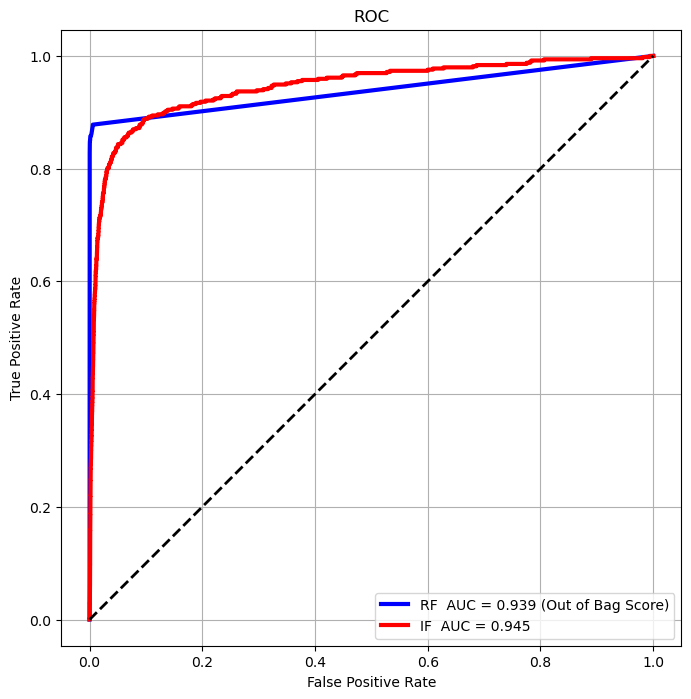

In [15]:
# Plot the ROC Curve

hF, hA = plt.subplots(figsize = FIG_SIZE_DEF)
hA.plot(vFP_RF, vTP_RF, color = 'b', lw = 3, label = f'RF  AUC = {AUC_RF :.3f} (Out of Bag Score)')
hA.plot(vFP_IF, vTP_IF, color = 'r', lw = 3, label = f'IF  AUC = {AUC_IF :.3f}')
hA.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = '--')
hA.set_title ('ROC')
hA.set_xlabel('False Positive Rate')
hA.set_ylabel('True Positive Rate')
hA.axis ('equal')
hA.legend()
hA.grid()

plt.show()

* <font color='red'>(**?**)</font> Which method is better by the AUC score?
* <font color='red'>(**?**)</font> Which method would you chose?

In [16]:
# Interpolate Performance by Threshold
v              = np.linspace(0, 1, numGrdiPts, endpoint = True)
vThersholdRF2  = np.interp(v, vFP_RF, vThersholdRF)
vThersholdIF2  = np.interp(v, vFP_IF, vThersholdIF)

In [17]:
def PlotConfusionMatrices(thrLvl):
    
    thrRF    = vThersholdRF2[thrLvl]
    thrIF    = vThersholdIF2[thrLvl]
    vHatY_RF = vScoreRF > thrRF
    vHatY_IF = vScoreIF > thrIF
        
    mC_RF = confusion_matrix(vY, vHatY_RF)
    mC_IF = confusion_matrix(vY, vHatY_IF)
    
    fig = plt.figure(figsize = (12, 8))
    ax  = fig.add_subplot(1, 2, 1)
    ax.plot(vFP_RF, vTP_RF, color = 'b', lw=3, label=f'RF AUC = {AUC_RF :.3f} (On train data)')
    ax.plot(vFP_IF, vTP_IF, color = 'r', lw=3, label=f'IF AUC = {AUC_IF :.3f}')
    ax.plot([0, 1], [0, 1], color = 'k', lw=2, linestyle='--')
    ax.axvline(x = thrLvl / (numGrdiPts - 1), color = 'g', lw = 2, linestyle = '--')
    ax.set_title ('ROC')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.axis      ('equal')
    ax.legend    ()
    ax.grid      ()    
    
    axRF = fig.add_subplot(2, 3, 3)
    axIF = fig.add_subplot(2, 3, 6)
    
    ConfusionMatrixDisplay(mC_RF, display_labels=['Normal', 'Fruad']).plot(ax=axRF)
    ConfusionMatrixDisplay(mC_IF, display_labels=['Normal', 'Fruad']).plot(ax=axIF)
    axRF.set_title('Random Forest   \n' f'f1_score = {f1_score(vY, vHatY_RF):1.4f}')
    axIF.set_title('Isolation Forest\n' f'f1_score = {f1_score(vY, vHatY_IF):1.4f}')
    plt.show        ()
    


In [18]:
# Interactive Plot
thrLvlSlider = IntSlider(min = 0, max = numGrdiPts - 1, step = 1, value = 0, layout = Layout(width = '30%'))
interact(PlotConfusionMatrices, thrLvl = thrLvlSlider)
plt.show()

interactive(children=(IntSlider(value=0, description='thrLvl', layout=Layout(width='30%'), max=200), Output())…

* <font color='brown'>(**#**)</font> In the above, due to the imbalanced properties of the data the AUC isn't a good score.

### Precision Recall Curve

For highly imbalanced data, the Precision Recall Curve is usually a better tool to analyze performance.

* <font color='brown'>(**#**)</font> The _Precision Recall Curve_ isn't guaranteed to be monotonic.

In [19]:
# Curve Vectors
vPR_RF, vRE_RF, vThersholdPrReRF = precision_recall_curve(vY, vScoreRF, pos_label = 1)
vPR_IF, vRE_IF, vThersholdPrReIF = precision_recall_curve(vY, vScoreIF, pos_label = 1)

# Average Precision Score, Somewhat equivalent to the AUC for the PR Curve
AUC_PrReRF = average_precision_score(vY, vScoreRF, pos_label = 1)
AUC_PrReIF = average_precision_score(vY, vScoreIF, pos_label = 1)

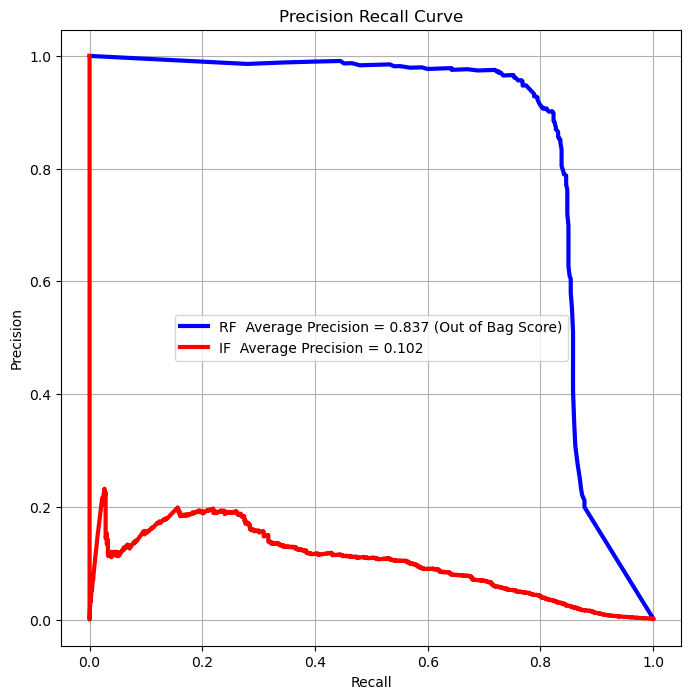

In [20]:
hF, hA = plt.subplots(figsize = FIG_SIZE_DEF)
hA.plot(vRE_RF, vPR_RF, color = 'b', lw = 3, label = f'RF  Average Precision = {AUC_PrReRF :.3f} (Out of Bag Score)')
hA.plot(vRE_IF, vPR_IF, color = 'r', lw = 3, label = f'IF  Average Precision = {AUC_PrReIF :.3f}')
hA.set_title ('Precision Recall Curve')
hA.set_xlabel('Recall')
hA.set_ylabel('Precision')
hA.axis('equal')
hA.legend()
hA.grid()
plt.show()

* <font color='red'>(**?**)</font> Which score would you optimize in the case above?

## summary

* supervised will be better because we have the labels
* 
